# Analyze sessions in batch from Phase 1 of AdaDrive (work in progress)

In [1]:
path_to_base_package = '../..'
import sys
# setting path
sys.path.append(f"{path_to_base_package}")
import mne
mne.viz.set_3d_backend('pyvistaqt')
mne.viz.set_3d_options(antialias=False) 

import json
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from mna.utils.data_access import *
from mna.utils.analysis import *
from mne.datasets import fetch_fsaverage
import pickle

# Download fsaverage files
fs_dir = fetch_fsaverage(verbose=True)

Using pyvistaqt 3d backend.

0 files missing from root.txt in /Users/schko/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /Users/schko/mne_data/MNE-fsaverage-data/fsaverage


# Aux functions, read files

In [2]:
output_dir = f"{path_to_base_package}/output/batch_analysis_motor/"
output_dir_non_baseline_non_average = f"{path_to_base_package}/output/batch_analysis_motor/saved_files_non_baseline_non_average/" # saved files directory (trial or motor)
remove_sessions = [(15,1),(22,1)]
rel_regions, all_region = get_relevant_channels()
rel_labels, rel_mappings = get_relevant_labels_mappings(path_to_base_package)

pupil_df = pd.read_csv(f"{path_to_base_package}/output/pupil_exposure/participant_level_exposure_fits.csv")
trial_dfs = pd.read_csv(f"{output_dir}all_results.csv")
motor_dfs = read_motor_csvs(output_dir)
motor_dfs['post_steer_event_raw'] = motor_dfs['post_steer_event_raw'].apply(str_list_to_list)
motor_epochs = get_motor_epochs(output_dir_non_baseline_non_average)
#low_motor_sensor = motor_epochs["Steer_Wheel_Degree_Categorical == 'Low'"]
#high_motor_sensor = motor_epochs["Steer_Wheel_Degree_Categorical == 'High'"]
#low_pupil = motor_epochs["pupil_bin == '{}'".format('low')]
#high_pupil =motor_epochs["pupil_bin == '{}'".format('high')]
exposure_epochs = get_exposure_epochs(f"{path_to_base_package}/output/exposure/exposure_epochs.pickle")
#low_motor_sensor.apply_proj()
#high_motor_sensor.apply_proj()

p_val_criteria = 0.05
preturn = 1000

Reading labels from parcellation...
   read 82 labels from /Users/schko/mne_data/MNE-fsaverage-data/fsaverage/label/lh.PALS_B12_Brodmann.annot
   read 46 labels from /Users/schko/mne_data/MNE-fsaverage-data/fsaverage/label/rh.PALS_B12_Brodmann.annot
reading participant-level motor data
found cleaned epochs
Adding metadata with 5 columns
509 matching events found
No baseline correction applied


# Clean up dfs

In [3]:
# seaborn
import math 
sns.set(font_scale=1.2)
sns.set_palette("tab10")
from mna.utils.batch_feature_extraction import clean_up_adadrive_trials

motor_outlier_cols = ['abs_sum_delta_steer_input']
cols_to_outlier_detect = ['bpm', 'sdnn', 'rmssd', 'pnn50']
experimental_cols = ['spoken_difficulty', 'trial_duration', 'density', 'trial_damage']
eye_cols = ['Left Pupil Diameter', "NSLR_count_Fixation", "NSLR_count_Saccade",
            'NSLR_mean_duration_Fixation', 'NSLR_mean_duration_Saccade',
            'NSLR_first_onset_Fixation', 'NSLR_first_onset_Saccade']
ecg_cols = ['bpm', 'sdnn', 'rmssd', 'pnn50']  # rmssd = parasympathetic
motor_cols = ['abs_sum_delta_steer_input', 'abs_sum_delta_brake_input', 'abs_sum_delta_throttle_input']
def remove_motor_overlaps(test_df):
    test_df = test_df.reset_index(drop=True)
    trial_list = list(zip(test_df.trial_start_time, test_df.trial_end_time, test_df.index))
    overlaps = []
    for i in range(1,len(trial_list)):
        base_data = trial_list[i]
        check_data = trial_list[i-1]
        if base_data[1] > check_data[0] and base_data[1] <= check_data[1]:
            overlaps.append((base_data, check_data, base_data[1]-check_data[0], base_data[2], check_data[2]))
            assert base_data[1]-check_data[0] != 1, 'Major issue, repeating trials found. Double check'
    drop_rows = []
    for overlap in overlaps:
        row_1 = test_df.iloc[overlap[-1]]
        row_2 = test_df.iloc[overlap[-2]]
        if np.argmax([row_1.Abs_Steer_Wheel_Degree, row_2.Abs_Steer_Wheel_Degree]) == 0: # if row 1 has larger steer motion, drop the other
            drop_rows.append(overlap[-2])
        else:
            drop_rows.append(overlap[-1])
    test_df = test_df.drop(drop_rows,axis=0)
    return test_df

def clean_up_trials(input_df):
    all_dfs_final = clean_up_adadrive_trials(input_df.copy())
    # damage change
    all_dfs_final = all_dfs_final.sort_values(by=['ppid', 'session', 'block', 'trial'])
    # nan, outliers
    #for col in motor_outlier_cols:
    #    all_dfs_final[col] = all_dfs_final[col].mask(all_dfs_final[col].sub(all_dfs_final[col].mean()).div(all_dfs_final[col].std()).abs().gt(2))
    #all_dfs_final['abs_sum_delta_brake_input'] = all_dfs_final['abs_sum_delta_brake_input'].mask(all_dfs_final['abs_sum_delta_brake_input']>.1)

    all_dfs_final['NSLR_first_onset_Fixation'] = all_dfs_final['NSLR_first_onset_Fixation'] - all_dfs_final[
        'trial_start_time']
    all_dfs_final['NSLR_first_onset_Saccade'] = all_dfs_final['NSLR_first_onset_Saccade'] - all_dfs_final[
        'trial_start_time']

    all_dfs_final[
        'throttle_over_brake'] = all_dfs_final.abs_sum_delta_throttle_input / all_dfs_final.abs_sum_delta_brake_input
    return all_dfs_final


trial_dfs = clean_up_trials(trial_dfs)
trial_dfs = trial_dfs.loc[~trial_dfs.ppid_session.isin([f"{es[0]}_{es[1]}" for es in remove_sessions])]
motor_dfs = clean_up_trials(motor_dfs)
print(f"removing ovlerlapping motor trials, starting epoch count {len(motor_dfs)}")
motor_dfs = remove_motor_overlaps(motor_dfs)
print(f"post removal epoch count {len(motor_dfs)}")
# luminance effect removal from pupil diameter
trial_dfs['Raw Left Pupil Diameter'] = trial_dfs['Left Pupil Diameter']
motor_dfs['Raw Left Pupil Diameter'] = motor_dfs['Left Pupil Diameter']
trial_dfs = trial_dfs.reset_index(drop=True)
adjustments=[]
for index, row in trial_dfs.iloc[1:].iterrows():
    last_ppid = trial_dfs.iloc[index - 1].ppid
    last_session = trial_dfs.iloc[index - 1].session
    last_trial = trial_dfs.iloc[index - 1].trial
    last_opacity = trial_dfs.iloc[index - 1].density
    if ((row.ppid == last_ppid) & (row.session == last_session) & (row.trial == last_trial + 1)):  # if continuous
        # if there is a significant effect of opacity on pupil
        if pupil_df.loc[pupil_df['sub'] == last_ppid, 'p_opacities'].values < p_val_criteria:
            this_opacity = row.density
            this_pupil_diameter = row['Left Pupil Diameter']
            weight = pupil_df.loc[pupil_df['sub'] == last_ppid, 'w_opacities']
            adjustment = ((this_opacity - last_opacity) * weight).values[0]
            trial_dfs.iloc[index, trial_dfs.columns.get_loc('Left Pupil Diameter')] += adjustment
            # this needs to be converted to array b/c of pandas issues
            old_pupil_value = np.array(motor_dfs.loc[(motor_dfs.ppid == last_ppid) & (motor_dfs.session == last_session) & (
                        motor_dfs.trial == last_trial + 1), 'Left Pupil Diameter']) 
            motor_dfs.loc[(motor_dfs.ppid == last_ppid) & (motor_dfs.session == last_session) & (
                        motor_dfs.trial == last_trial + 1), 'Left Pupil Diameter'] = (old_pupil_value-adjustment).T  # update motor df too
            # do also for motor_epochs
            old_pupil_value = motor_epochs.metadata.loc[(motor_epochs.metadata.ppid == last_ppid) &
                                      (motor_epochs.metadata.session == last_session) &
                                      (motor_epochs.metadata.trial == last_trial + 1), 'Left Pupil Diameter']
            motor_epochs.metadata.loc[(motor_epochs.metadata.ppid == last_ppid) &
                                      (motor_epochs.metadata.session == last_session) &
                                      (motor_epochs.metadata.trial == last_trial + 1), 'Left Pupil Diameter'] = (old_pupil_value-adjustment).T
# pupil bins
motor_dfs['pupil_bin'] = motor_dfs.groupby(['ppid'])['Left Pupil Diameter'].transform(
    lambda x: pd.qcut(x, 2, labels=['low', 'high']))
trial_dfs['pupil_bin'] = trial_dfs.groupby(['ppid'])['Left Pupil Diameter'].transform(
    lambda x: pd.qcut(x, 2, labels=['low', 'high']))
motor_epochs.metadata['pupil_bin'] = motor_epochs.metadata.groupby(['ppid'])['Left Pupil Diameter'].transform(
    lambda x: pd.qcut(x, 2, labels=['low', 'high']))
motor_dfs['pupil_bin_encoded'] = motor_dfs.groupby(['ppid'])['Left Pupil Diameter'].transform(
    lambda x: pd.qcut(x, 2, labels=[0, 1]))
trial_dfs['pupil_bin_encoded'] = trial_dfs.groupby(['ppid'])['Left Pupil Diameter'].transform(
    lambda x: pd.qcut(x, 2, labels=[0, 1]))
motor_epochs.metadata['pupil_bin_encoded'] = motor_epochs.metadata.groupby(['ppid'])['Left Pupil Diameter'].transform(
    lambda x: pd.qcut(x, 2, labels=[0, 1]))


# participant-level binning of motor data, replaces the session-level info already there
motor_dfs = get_motor_intensity_info(motor_dfs)
motor_epochs.metadata = get_motor_intensity_info(motor_epochs.metadata)


# ensure that epochs that removed from motor epochs are also removed from EEG analysis (we don't do the reverse since we have non-eeg, usable data)
df_all = motor_epochs.metadata[['ppid', 'session', 'block', 'trial']].merge(motor_dfs[['ppid', 'session', 'block', 'trial']].drop_duplicates(), on=['ppid', 'session', 'block', 'trial'], 
                   how='inner', indicator=True)
i1 = motor_epochs.metadata.set_index(['ppid', 'session', 'block', 'trial']).index
i2 = df_all.set_index(['ppid', 'session', 'block', 'trial']).index
motor_epochs = motor_epochs[i1.isin(i2)]
# motor_epochs.set_eeg_reference('average') # custom eeg reference is not allowed for MNE source modeling
motor_epochs.apply_baseline((-((preturn+250) / 1000), -((preturn) / 1000)))
print(pupil_df[['sub','w_opacities','const','p_opacities']].to_latex(index=False,float_format="{:0.2f}".format))

removing ovlerlapping motor trials, starting epoch count 6291
post removal epoch count 6218
Replacing existing metadata with 75 columns
Applying baseline correction (mode: mean)
\begin{tabular}{rrrr}
\toprule
 sub &  w\_opacities &  const &  p\_opacities \\
\midrule
  20 &        -0.63 &   0.80 &         0.00 \\
  14 &        -0.15 &   0.24 &         0.00 \\
  12 &        -1.06 &   0.96 &         0.00 \\
  22 &        -1.18 &   1.33 &         0.00 \\
  16 &        -0.27 &   0.37 &         0.00 \\
  18 &        -1.23 &   0.98 &         0.00 \\
  19 &         0.34 &  -0.13 &         0.00 \\
  21 &        -0.44 &   0.46 &         0.00 \\
  15 &        -3.06 &   2.15 &         0.00 \\
  13 &        -1.11 &   1.13 &         0.00 \\
  23 &        -0.55 &   0.58 &         0.00 \\
  17 &        -0.60 &   0.45 &         0.00 \\
\bottomrule
\end{tabular}



# eLORETA

## Load forward model, create inverse operator

In [4]:
subjects_dir = os.path.dirname(fs_dir)

# The files live in:
subject = 'fsaverage'
trans = 'fsaverage'  # MNE has a built-in fsaverage transformation
'''
select the boundary element model, note that the source data has been downsampled by a factor of 5 
(i.e. ico == 5, https://mne.tools/stable/generated/mne.setup_source_space.html#mne.setup_source_space)
and the BEM has been downsampled by a factor of 5 (i.e. ico == 4, see here: https://mne.tools/stable/generated/mne.make_bem_model.html)
implications here: https://brainder.org/2016/05/31/downsampling-decimating-a-brain-surface/
'''
src_fname = os.path.join(fs_dir, 'bem', 'fsaverage-ico-5-src.fif')
bem = os.path.join(fs_dir, 'bem', 'fsaverage-5120-5120-5120-bem-sol.fif')

eeg_montage='biosemi64'
info = motor_epochs.info

# Read and set the EEG electrode locations, which are already in fsaverage's
# space (MNI space) for standard_1020:
montage = mne.channels.make_standard_montage(eeg_montage)

# Check that the locations of EEG electrodes is correct with respect to MRI
# mne.viz.plot_alignment(
#    info, src=src_fname, eeg=['original', 'projected'], trans=trans,
#    show_axes=False, mri_fiducials=True, dig='fiducials')
fwd = mne.make_forward_solution(info, trans=trans, src=src_fname,
                                bem=bem, eeg=True, n_jobs=None)

Source space          : /Users/schko/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif
MRI -> head transform : /Users/schko/.conda/envs/mna/lib/python3.10/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : /Users/schko/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-5120-5120-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Reading /Users/schko/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif...
Read 2 source spaces a total of 20484 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  64 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.

Setting up the BEM 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


    Found     0/ 7809 points outside using solid angles
    Total 10242/10242 points inside the surface
Interior check completed in 2309.6 ms
Checking surface interior status for 10242 points...
    Found  2241/10242 points inside  an interior sphere of radius   47.7 mm
    Found     0/10242 points outside an exterior sphere of radius   98.3 mm
    Found     0/ 8001 points outside using surface Qhull


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


    Found     0/ 8001 points outside using solid angles
    Total 10242/10242 points inside the surface
Interior check completed in 2319.1 ms

Setting up for EEG...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s finished


Computing EEG at 20484 source locations (free orientations)...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Finished.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.0s finished


Computing rank from data with rank=None
    Using tolerance 6.1e-07 (2.2e-16 eps * 64 dim * 4.3e+07  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using SHRUNK
Done.
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
    EEG regularization : 0.1
    EEG regularization : 0.1
    EEG regularization : 0.1
Number of samples used : 326269
log-likelihood on unseen data (descending order):
   shrunk: -706.964
   diagonal_fixed: -794.575
   empirical: -338786.930
selecting best estimator: shrunk
[done]
Computing rank from covariance with rank=None
    Using tolerance 2.4e-07 (2.2e-16 eps * 64 dim * 1.7e+07  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors


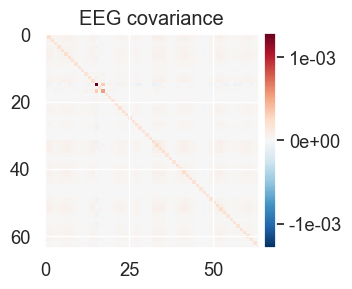

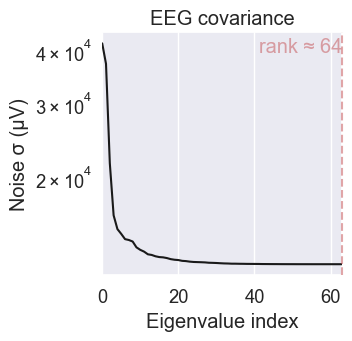

Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 64 channels.
    64 out of 64 channels remain after picking
Selected 64 channels
Creating the depth weighting matrix...
    64 EEG channels
    limit = 20485/20484 = 2.329337
    scale = 108975 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 2.2e-07 (2.2e-16 eps * 64 dim * 1.5e+07  max singular value)
    Estimated rank (eeg): 63
    EEG: rank 63 computed from 64 data channels with 1 projector
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD

In [5]:
method = "eLORETA"
snr = 3.
lambda2 = 1. / snr ** 2
cov = mne.compute_covariance(exposure_epochs, method='auto') # note this is not average referenced
cov.plot(exposure_epochs.info)
inverse_operator = mne.minimum_norm.make_inverse_operator(
    info, fwd, cov)
#low_motor = get_forward_results(output_dir, 'low',low_motor_sensor,inverse_operator,fwd, lambda2)
#high_motor = get_forward_results(output_dir, 'high',high_motor_sensor,inverse_operator,fwd, lambda2)

In [11]:
def get_time_courses(input_epochs, input_labels):
    # Average the source estimates within each label of the cortical parcellation
    # and each sub-structure contained in the source space.
    # When mode = 'mean_flip', this option is used only for the cortical labels.
    src = inverse_operator['src']
    rel_stcs = mne.minimum_norm.apply_inverse_epochs(input_epochs, inverse_operator,
                                    lambda2=1.0 / snr ** 2, verbose=False,
                                    method="eLORETA", pick_ori="normal")
    label_ts = mne.extract_label_time_course(
        rel_stcs, input_labels, src, mode='mean_flip', allow_empty=True,
        return_generator=True, verbose=False)
    return label_ts

def get_all_tcs(output_dir, overwrite=False):
    if not overwrite and os.path.isfile(f"{output_dir}source_time_courses.pickle"):
        all_cond_tcs_df = pickle.load(open(f"{output_dir}source_time_courses.pickle", 'rb'))
        return all_cond_tcs_df
    else:
        all_cond_tcs = []
        pps = motor_epochs.metadata['ppid'].unique()
        for this_pid in pps:
            print('this_pid',this_pid)
            this_pid_df = motor_epochs.metadata[motor_epochs.metadata['ppid']==this_pid]
            nested_df = this_pid_df[this_pid_df['Steer_Wheel_Degree_Categorical']=='Low']
            st = set(nested_df.trial_start_time)
            relevant_indices = [i for i, e in enumerate(motor_epochs.metadata.trial_start_time) if e in st]
            low_pp_epochs = motor_epochs[relevant_indices] # note that motor_epochs index is not the same as the motor_epochs.metadata df index so we need to do this

            nested_df = this_pid_df[this_pid_df['Steer_Wheel_Degree_Categorical']=='High']
            st = set(nested_df.trial_start_time)
            relevant_indices = [i for i, e in enumerate(motor_epochs.metadata.trial_start_time) if e in st]
            high_pp_epochs = motor_epochs[relevant_indices] # note that motor_epochs index is not the same as the motor_epochs.metadata df index so we need to do this

            ret_tcs = get_time_courses(low_pp_epochs, rel_labels)
            global_trials = list(low_pp_epochs.metadata.trial)
            global_sessions = list(low_pp_epochs.metadata.session)
            all_low_tcs = []
            for indx, t in enumerate(ret_tcs):
                trial_df = pd.DataFrame(t)
                trial_df = trial_df.T
                trial_df.columns = [l.name for l in rel_labels]
                trial_df['motor_event_trial'] = indx
                trial_df['trial'] = global_trials[indx]
                trial_df['session'] = global_sessions[indx]
                trial_df['time'] = trial_df.index
                trial_df['pid'] = this_pid
                all_low_tcs.append(trial_df)
            all_low_tcs = pd.concat(all_low_tcs)
            all_low_tcs['cond'] = 'low'

            ret_tcs = get_time_courses(high_pp_epochs,rel_labels)
            global_trials = list(high_pp_epochs.metadata.trial)
            global_sessions = list(low_pp_epochs.metadata.session)
            all_high_tcs = []
            for indx, t in enumerate(ret_tcs):
                trial_df = pd.DataFrame(t)
                trial_df = trial_df.T
                trial_df.columns = [l.name for l in rel_labels]
                trial_df['motor_event_trial'] = indx
                trial_df['trial'] = global_trials[indx]
                trial_df['session'] = global_sessions[indx]
                trial_df['time'] = trial_df.index
                trial_df['pid'] = this_pid
                all_high_tcs.append(trial_df)
            all_high_tcs = pd.concat(all_high_tcs)
            all_high_tcs['cond'] = 'high'
            all_cond_tcs.append(pd.concat([all_low_tcs,all_high_tcs]))
            
        all_cond_tcs_df = pd.concat(all_cond_tcs)
        all_cond_tcs_df = pd.melt(all_cond_tcs_df, id_vars=['motor_event_trial','trial','session','time','pid','cond'],value_name='activation',var_name='source_region')
        with open(f"{output_dir}source_time_courses.pickle", 'wb') as handle_ica:
            pickle.dump(all_cond_tcs_df, handle_ica, protocol=pickle.HIGHEST_PROTOCOL)
    return all_cond_tcs_df
all_tcs = get_all_tcs(output_dir_non_baseline_non_average,overwrite=False)